In [29]:
# Imports and data load
import pandas as pd
import glob

# Define path to dataset folder (one level up from notebooks/)
data_dir = "../dataset"
files = sorted(glob.glob(f"{data_dir}/*.csv.gz"))

# Load and concatenate all .csv.gz files
if files:
    df = pd.concat((pd.read_csv(f, compression="gzip") for f in files), ignore_index=True)
    print(f"Loaded {len(df):,} rows from {len(files)} files")
    display(df.head())
else:
    print("No files found — check the path.")


Loaded 7,293,526 rows from 17 files


,user_id,event_date,platform,install_date,country,total_session_count,total_session_duration,match_start_count,match_end_count,victory_count,defeat_count,server_connection_error,iap_revenue,ad_revenue
0,C6C0A027C49B98BA,2024-02-16,android,2024-02-11,NaN,1,57.721,0,0,0,0,0,0.0,0.0
1,EE03D492BC0ED08C,2024-03-08,ios,2024-02-01,NaN,0,0.355,0,0,0,0,0,0.0,0.0
2,5CAA4AF817354059,2024-03-12,ios,2024-03-12,NaN,1,114.006,0,0,0,0,0,0.0,0.0
3,EF0DE79217D56E72,2024-02-16,ios,2023-07-24,NaN,0,8.157,0,0,0,0,0,0.0,0.0
4,6DD3D1FC631486F0,2024-03-02,android,2024-03-01,NaN,1,233.265,1,0,0,0,0,0.0,0.0


In [30]:
# Data Cleaning

# Drop rows missing core identifiers or timestamps
df = df.dropna(subset=["user_id", "event_date", "install_date"])

# Remove duplicates, if any
df = df.drop_duplicates()

# Remove rows with invalid or zero session data
df = df[df["total_session_count"] > 0]
df = df[df["total_session_duration"] > 0]

# Filter out rows with negative revenue
df = df[(df["iap_revenue"] >= 0) & (df["ad_revenue"] >= 0)]

# Drop rows with NaNs in numeric fields used later
df = df.dropna(subset=[
    "total_session_count", 
    "total_session_duration", 
    "iap_revenue", 
    "ad_revenue"
])

# Optional: check size after cleaning
print(f"Cleaned dataset has {len(df):,} rows and {df['user_id'].nunique():,} unique users.")


Cleaned dataset has 7,112,028 rows and 2,418,983 unique users.


In [31]:
# Sanity Checks After Cleaning

# Confirm no missing values in critical columns
assert df["user_id"].notna().all(), "Some user_id values are still missing"
assert df["event_date"].notna().all(), "Missing event_date values remain"
assert df["install_date"].notna().all(), "Missing install_date values remain"

# Confirm session data is valid
assert (df["total_session_count"] > 0).all(), "Some rows still have 0 or negative sessions"
assert (df["total_session_duration"] > 0).all(), "Some rows still have 0 or negative session duration"

# Confirm revenue values are valid
assert (df["iap_revenue"] >= 0).all(), "Some rows still have negative IAP revenue"
assert (df["ad_revenue"] >= 0).all(), "Some rows still have negative ad revenue"

print("Data passed all post-cleaning checks.")


Data passed all post-cleaning checks.


In [32]:
# Make sure date columns are datetime
df["install_date"] = pd.to_datetime(df["install_date"])
df["event_date"] = pd.to_datetime(df["event_date"])

# Create days_since_install feature
df["days_since_install"] = (df["event_date"] - df["install_date"]).dt.days

In [33]:
# Robust D1 segmentation with auto-adjusted bins

# Filter D1 rows (install day = day 0)
d1_data = df[df["days_since_install"] == 0]

# Aggregate engagement per user
engagement = (
    d1_data.groupby("user_id")[["total_session_count", "total_session_duration"]]
    .sum()
    .reset_index()
)

# Use qcut to get bin edges, drop duplicates to avoid overlap errors
session_bins = pd.qcut(
    engagement["total_session_count"], 
    q=4, 
    duplicates="drop"
)
duration_bins = pd.qcut(
    engagement["total_session_duration"], 
    q=4, 
    duplicates="drop"
)

# Use pd.cut with the actual bin edges, and assign readable string bins
engagement["session_bin"] = pd.cut(
    engagement["total_session_count"],
    bins=session_bins.cat.categories,
    include_lowest=True
).astype(str)

engagement["duration_bin"] = pd.cut(
    engagement["total_session_duration"],
    bins=duration_bins.cat.categories,
    include_lowest=True
).astype(str)

# Merge bins back into main df
df = df.merge(
    engagement[["user_id", "session_bin", "duration_bin"]],
    on="user_id",
    how="left"
)


In [34]:
# Focus on first 30 days only
df_30 = df[df["days_since_install"] < 30]

# Group by engagement level and aggregate revenue
grouped = (
    df_30.groupby("session_bin")[["iap_revenue", "ad_revenue"]]
    .sum()
    .assign(total_revenue=lambda d: d["iap_revenue"] + d["ad_revenue"])
    .reset_index()
)

display(grouped)


,session_bin,iap_revenue,ad_revenue,total_revenue
0,"(0.999, 2.0]",106067.716357,42603.703557,148671.419914
1,"(2.0, 18.0]",48585.894900,13323.361432,61909.256331


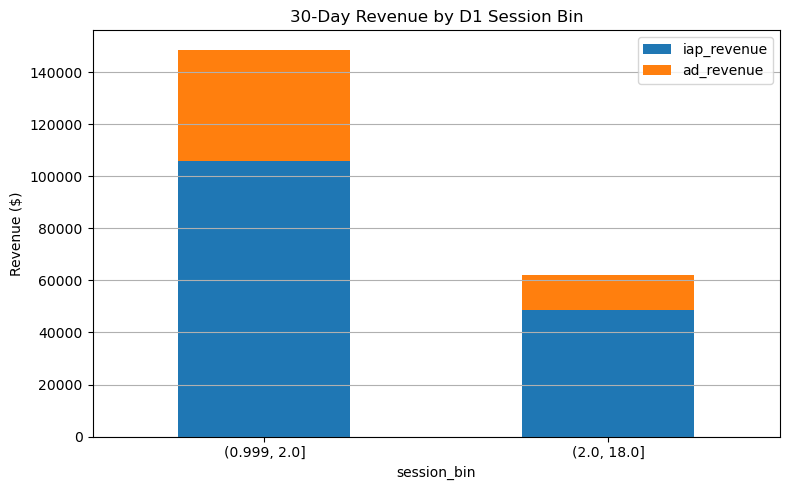

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

grouped.set_index("session_bin")[["iap_revenue", "ad_revenue"]].plot(
    kind="bar",
    stacked=True,
    ax=ax,
    ylabel="Revenue ($)",
    title="30-Day Revenue by D1 Session Bin"
)

plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


### Session Count Segmentation (D1)

Grouped users based on how many sessions they played on Day 1 and calculated their 30-day monetization. The results showed:

* Users with only 1–2 sessions generated more than twice the revenue of those with 3 or more.
* The majority of this revenue came from in-app purchases, with ads contributing less.

This is likely due to higher user volume in the low-session group, or that some high-value users churn quickly despite playing only a couple sessions. While interesting, it’s not as actionable alone — further segmentation (e.g. cross-analyzing session count and duration) might add clarity.

In [12]:
# Filter Day 1 users
df_d1 = df[df["days_since_install"] == 0].copy()

# Safety check: make sure there are valid durations
print("Max D1 session duration:", df_d1["total_session_duration"].max())

# Define duration bins: Short = ≤5 minutes (300 sec), Long = >5 min
duration_bins = [0, 300, df_d1["total_session_duration"].max()]
duration_labels = ["Short (≤5 min)", "Long (>5 min)"]

# Assign duration bin labels
df_d1["duration_bin"] = pd.cut(
    df_d1["total_session_duration"],
    bins=duration_bins,
    labels=duration_labels,
    include_lowest=True
)

# Merge duration_bin into full df by user_id
df = df.merge(df_d1[["user_id", "duration_bin"]], on="user_id", how="left")


Max D1 session duration: 1233540.84


In [14]:
revenue_by_duration = (
    df.groupby("duration_bin", observed=False)[["iap_revenue", "ad_revenue"]]
    .sum()
    .assign(total_revenue=lambda d: d["iap_revenue"] + d["ad_revenue"])
)


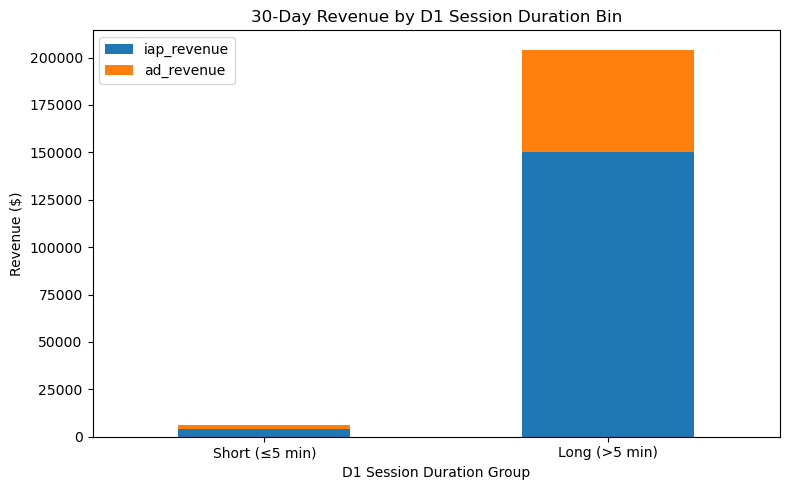

In [15]:
rev_by_duration[["iap_revenue", "ad_revenue"]].plot(
    kind="bar", stacked=True, figsize=(8, 5),
    title="30-Day Revenue by D1 Session Duration Bin"
)
plt.ylabel("Revenue ($)")
plt.xlabel("D1 Session Duration Group")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Session Count Segmentation (D1)

We split users based on Day 1 session duration (short ≤5 min vs. long >5 min). The findings were very clear:
* Users with longer D1 sessions (>5 minutes) generated over 200K in revenue.
* Users with short sessions (≤5 min) barely contributed, totaling just a small fraction of that.
* In-app purchases drove most of the difference, with ad revenue contributing as well.

This shows early engagement is a strong signal of user value. Users who stay longer on Day 1 are far more likely to monetize over time. This insight can guide onboarding improvements or targeting for high-quality acquisition campaigns.

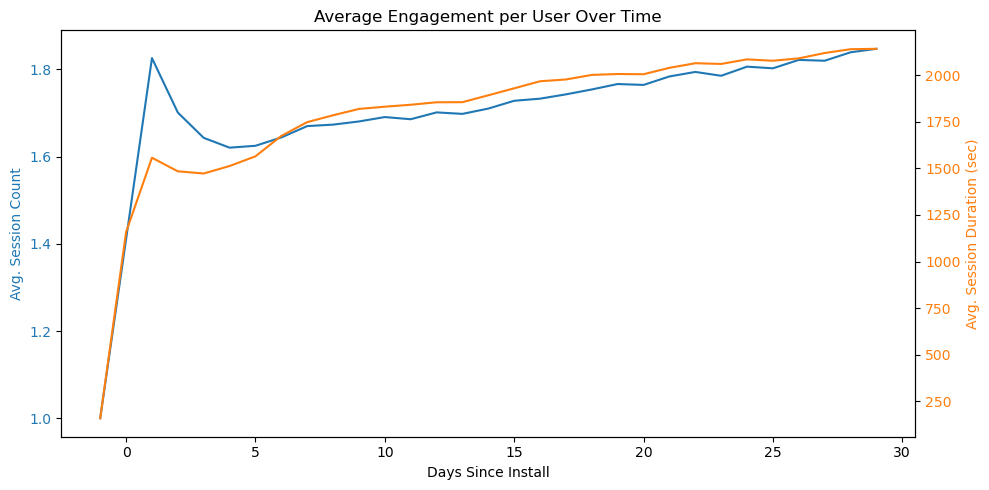

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:blue'
color2 = 'tab:orange'

# Plot session count on left axis
ax1.set_xlabel("Days Since Install")
ax1.set_ylabel("Avg. Session Count", color=color1)
ax1.plot(daily_avg.index, daily_avg["total_session_count"], color=color1, label="Avg. Session Count")
ax1.tick_params(axis='y', labelcolor=color1)

# Plot session duration on right axis
ax2 = ax1.twinx()
ax2.set_ylabel("Avg. Session Duration (sec)", color=color2)
ax2.plot(daily_avg.index, daily_avg["total_session_duration"], color=color2, label="Avg. Session Duration")
ax2.tick_params(axis='y', labelcolor=color2)

# Titles and layout
plt.title("Average Engagement per User Over Time")
fig.tight_layout()
plt.show()


### Average Engagement per User Over Time

This chart shows how user engagement changes during the first 30 days after install. We looked at two metrics: average session count and average session duration per user per day.

- On Day 1, both session count and duration jump sharply. This is expected as users explore the game.
- In the days after, there is a small drop, but both metrics steadily increase over time.
- By Day 30, users are playing more sessions per day and for longer durations compared to earlier days.

This suggests that users who stay past the first few days tend to become more engaged. Keeping users beyond Day 1 can lead to higher long-term activity.


In [37]:
# Ensure clean working copy
df_30 = df[df["days_since_install"] < 30].copy()

# Week number
df_30["week_since_install"] = (df_30["days_since_install"] // 7).astype(int)

# Total session duration over 30d per user
weekly_time = (
    df_30.groupby("user_id", as_index=False)["total_session_duration"]
    .sum()
    .rename(columns={"total_session_duration": "total_time_spent_30d"})
)

# Bin into quantiles
weekly_time["time_spent_segment"] = pd.qcut(
    weekly_time["total_time_spent_30d"],
    q=3,
    labels=["Low", "Medium", "High"]
)

# Debugging step: check if bins were created
print("Preview of user segments:")
display(weekly_time.head())

# Merge back into df_30
df_30 = df_30.merge(weekly_time[["user_id", "time_spent_segment"]], on="user_id", how="left")

# Debugging step: check merge success
print("Sample df_30 rows after merge:")
display(df_30[["user_id", "time_spent_segment"]].drop_duplicates().head())
print("Missing segment values:", df_30["time_spent_segment"].isna().sum())

# Group by segment and calculate revenue
revenue_by_time = (
    df_30.groupby("time_spent_segment", observed=False)[["iap_revenue", "ad_revenue"]]
    .sum()
    .assign(total_revenue=lambda d: d["iap_revenue"] + d["ad_revenue"])
    .sort_values("total_revenue", ascending=False)
)

display(revenue_by_time)


Preview of user segments:


,user_id,total_time_spent_30d,time_spent_segment
0,1000038539402B14,445.719,Medium
1,10001BC582D7177,2632.846,High
2,1000224DD5D0F05F,2057.552,High
3,1000238B392C0BBC,304.858,Low
4,100034D220D867B,639.180,Medium


Sample df_30 rows after merge:


,user_id,time_spent_segment
0,C6C0A027C49B98BA,Low
1,5CAA4AF817354059,Low
2,6DD3D1FC631486F0,Low
3,F360F40FCF2C1375,Low
4,C91A6125B3D88B92,Low


Missing segment values: 0


,iap_revenue,ad_revenue,total_revenue
time_spent_segment,,,
High,280479.733805,73793.705459,354273.439264
Medium,2952.026890,5262.160960,8214.187850
Low,97.586574,406.564540,504.151113


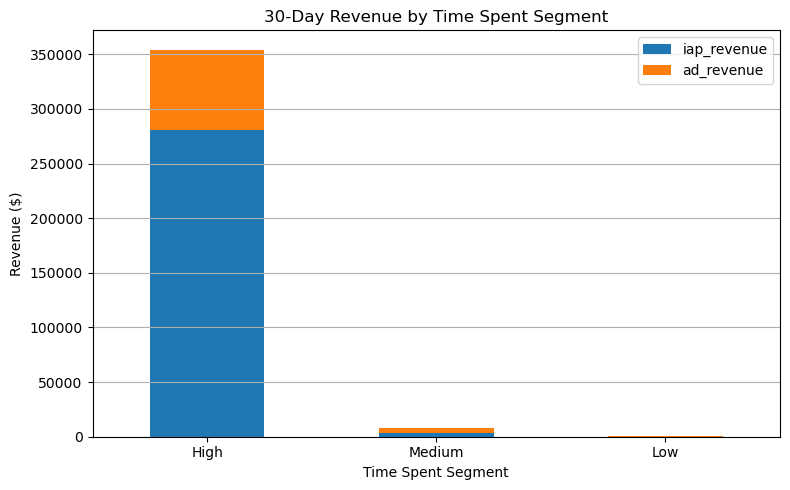

In [38]:
import matplotlib.pyplot as plt

# Plot stacked bar chart of IAP + Ad Revenue by time segment
revenue_by_time[["iap_revenue", "ad_revenue"]].plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    title="30-Day Revenue by Time Spent Segment"
)

plt.xlabel("Time Spent Segment")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [39]:
# Only keep rows with valid time_spent_segment
time_segmented = df_30[df_30["time_spent_segment"].notna()].copy()

# Group by segment and calculate average behavior metrics
time_segment_behavior = (
    time_segmented.groupby("time_spent_segment", observed=False)[
        ["total_session_duration", "match_start_count", "match_end_count", "iap_revenue", "ad_revenue"]
    ]
    .mean()
    .round(2)
    .assign(
        total_revenue=lambda d: d["iap_revenue"] + d["ad_revenue"],
        match_completion_rate=lambda d: d["match_end_count"] / d["match_start_count"]
    )
)

display(time_segment_behavior)


,total_session_duration,match_start_count,match_end_count,iap_revenue,ad_revenue,total_revenue,match_completion_rate
time_spent_segment,,,,,,,
Low,171.13,1.14,0.83,0.00,0.00,0.00,0.728070
Medium,570.08,2.18,1.93,0.00,0.01,0.01,0.885321
High,2309.07,6.11,5.32,0.14,0.04,0.18,0.870704


### Time Spent Segments: Engagement and Monetization Patterns

Users were segmented into Low, Medium, and High groups based on total time spent in the game over their first 30 days. The results show a strong correlation between time spent and monetization.

- High-time users drove nearly all revenue, mostly through in-app purchases. They also had the highest gameplay engagement, averaging over 6 matches started and 2300 seconds of session time.
- Medium users played less and contributed modestly, mostly via ads.
- Low-time users showed very low engagement and almost no monetization.

Match completion rate was highest among medium and high-time users, indicating stronger quality of play. These insights support focusing on onboarding and retaining users who engage early and often, as they are far more likely to convert into high-value players.


In [43]:
# Compute total revenue per user over 30 days
user_revenue = (
    df_30.groupby("user_id", as_index=False)[["iap_revenue", "ad_revenue"]]
    .sum()
    .assign(total_revenue=lambda d: d["iap_revenue"] + d["ad_revenue"])
)

# Filter to users with revenue > 0
spenders = user_revenue[user_revenue["total_revenue"] > 0].copy()

# Create spend segments using quantiles (tertiles)
spenders["spend_segment"] = pd.qcut(
    spenders["total_revenue"],
    q=3,
    labels=["Low", "Medium", "High"]
)

# Merge segment info back into df_30
df_30 = df_30.merge(spenders[["user_id", "spend_segment"]], on="user_id", how="left")

# Preview
print("Sample spender segments:")
display(spenders.head())

print("Spender segment distribution:")
display(spenders["spend_segment"].value_counts())


Sample spender segments:


,user_id,iap_revenue,ad_revenue,total_revenue,spend_segment
1,10001BC582D7177,0.0,0.018836,0.018836,Medium
2,1000224DD5D0F05F,0.0,0.003723,0.003723,Low
3,1000238B392C0BBC,0.0,0.018679,0.018679,Medium
6,100038AB6184304,0.0,0.019229,0.019229,Medium
7,10003FE04D7FA58,0.0,1.483007,1.483007,High


Spender segment distribution:


spend_segment
Medium    198822
Low       198496
High      198170
Name: count, dtype: int64

In [44]:
spender_behavior = (
    df_30[df_30["spend_segment"].notna()]
    .groupby("spend_segment", observed=False)[["total_session_duration", "match_start_count", "match_end_count"]]
    .mean()
    .round(2)
)

display(spender_behavior)


,total_session_duration,match_start_count,match_end_count
spend_segment,,,
Low,983.63,3.12,2.71
Medium,1388.31,4.11,3.54
High,3162.23,7.93,6.96


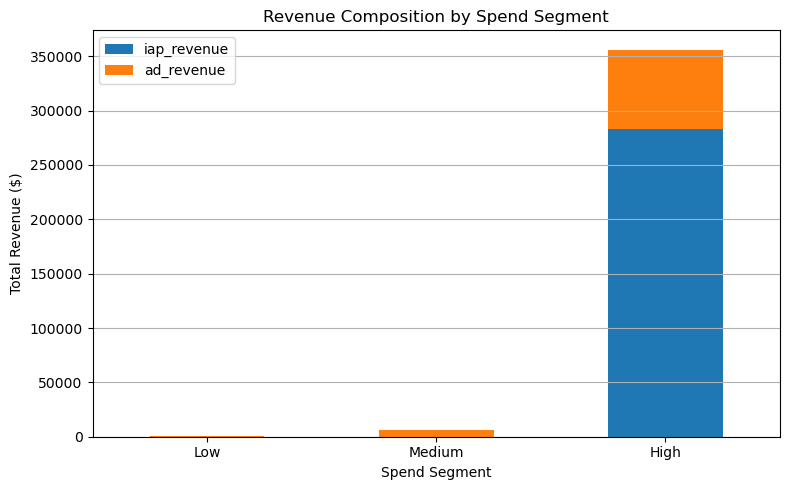

In [45]:
spender_revenue = (
    df_30[df_30["spend_segment"].notna()]
    .groupby("spend_segment", observed=False)[["iap_revenue", "ad_revenue"]]
    .sum()
)

spender_revenue.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    title="Revenue Composition by Spend Segment"
)
plt.ylabel("Total Revenue ($)")
plt.xlabel("Spend Segment")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


### Spender Segment Analysis: Engagement and Revenue Breakdown

Users were segmented into Low, Medium, and High tiers based on total revenue (IAP + ads) generated in the first 30 days. Only paying users were included in this segmentation.

- High spenders showed the most engagement by far, with over 3100 seconds of session time and nearly 8 matches started on average.
- Medium spenders were moderately engaged, with around 4 matches and 1300+ seconds of session time.
- Low spenders showed lower engagement, though still notably higher than the average non-spender.

The revenue composition chart confirms that high spenders drive the overwhelming majority of both IAP and ad revenue, while medium and low spenders contribute only a small fraction. These findings reinforce the importance of identifying high-potential users early, as their engagement levels strongly correlate with spending behavior.


In [46]:
# Aggregate match outcomes per user
user_skill = (
    df_30.groupby("user_id", as_index=False)[["victory_count", "match_end_count"]]
    .sum()
)

# Calculate win rate
user_skill["win_rate"] = user_skill["victory_count"] / user_skill["match_end_count"]

# Filter out users with too few matches (e.g., <5 completed)
user_skill = user_skill[user_skill["match_end_count"] >= 5].copy()

# Segment users by win_rate into Low / Medium / High skill
user_skill["skill_segment"] = pd.qcut(
    user_skill["win_rate"],
    q=3,
    labels=["Low", "Medium", "High"]
)

# Merge skill segment into df_30
df_30 = df_30.merge(user_skill[["user_id", "skill_segment"]], on="user_id", how="left")

# Analyze behavior by skill group
skill_behavior = (
    df_30[df_30["skill_segment"].notna()]
    .groupby("skill_segment", observed=False)[
        ["total_session_duration", "match_start_count", "match_end_count", "iap_revenue", "ad_revenue"]
    ]
    .mean()
    .round(2)
    .assign(total_revenue=lambda d: d["iap_revenue"] + d["ad_revenue"])
)

display(skill_behavior)


,total_session_duration,match_start_count,match_end_count,iap_revenue,ad_revenue,total_revenue
skill_segment,,,,,,
Low,2956.11,7.59,6.63,0.13,0.04,0.17
Medium,1463.25,4.30,3.81,0.13,0.03,0.16
High,1439.91,4.38,3.84,0.15,0.03,0.18


### Skill-Based Segmentation: Win Rate and Player Behavior

We segmented users into Low, Medium, and High skill groups based on their win rate (victory_count / match_end_count), using only users who completed at least 5 matches.

Surprisingly, the Low-skill group showed the highest session duration and match activity, averaging over 2950 seconds and more than 7 matches started. In contrast, Medium and High-skill users showed similar, but lower, engagement levels.

Despite the difference in gameplay time, all three skill segments generated nearly the same amount of revenue per user (~$0.16–0.18). This suggests that skill level alone does not predict monetization. In fact, lower-skill users may play more and stay longer, possibly due to needing more time to progress, which drives up their session time.

This insight highlights that lower-skilled users can still be highly valuable — both in engagement and monetization — and shouldn’t be overlooked when designing retention or monetization strategies.
